

### Architecture
In this experiment, EfficientNet_B0 is applied and last layer is removed with single output for the pawpularity finetuning without metadata inclusion. Some very basic augmentation (horizontal flipping) is added.

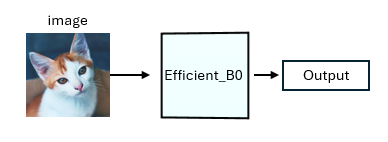

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [3]:
#  imports & setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import gc

gc.enable()

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageOnlyDataset
from src.models import build_vision_backbone
from src.train import train_one_epoch_image, validate_image

main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp2")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp2"]

TARGET = "Pawpularity"
tab_cols = [c for c in df.columns if c not in ["Id", TARGET]]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/ghias/miniconda3/envs/rapids-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from src.train import run_single_fold
import time

kf = KFold(n_splits=cfg["n_splits"], shuffle=True, random_state=cfg["seed"])
oof_pred = np.zeros(len(df))
oof_true = df[TARGET].values
fold_index = np.full(len(df), -1, dtype=int)
fold_rmse = []

# id2idx = {id_: i for i, id_ in enumerate(df["Id"].values)}
start_all = time.time()

for fold, (tr_idx, val_idx) in enumerate(kf.split(df), start=1):
    print(f"\n=== {cfg['name']}: Fold {fold} ===")
    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)

    best_rmse, val_preds, val_targets, val_ids = run_single_fold(
        fold=fold,
        train_df=train_df,
        val_df=val_df,
        img_folder=img_folder,
        cfg=cfg,
        out_dir=out_dir,
        device=device,
        mode="image",
        tab_cols=None,
        workers=16,
        pin_memory=True,
        persistent_workers=True,
    )

    oof_pred[val_idx] = val_preds
    fold_index[val_idx] = fold
    
    fold_rmse.append(best_rmse)
    print(f"Fold {fold} best RMSE: {best_rmse:.4f}")


all_sec = time.time() - start_all
print(f"\nTotal training time: {int(all_sec//60)}m {int(all_sec%60)}s")
# final metrics + OOF with fold column
oof_rmse = root_mean_squared_error(oof_true, oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"\nOOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "fold": fold_index,     
    "ytrue": oof_true,
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)

np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")



=== Exp2_EffNetB0_256_Lite: Fold 1 ===
Epoch 1/10 | Fold 1 TrainLoss: 746.0004 ValRMSE: 20.7584
Epoch 2/10 | Fold 1 TrainLoss: 354.7278 ValRMSE: 19.9883
Epoch 3/10 | Fold 1 TrainLoss: 310.7959 ValRMSE: 19.8657
Epoch 4/10 | Fold 1 TrainLoss: 277.8849 ValRMSE: 19.7338
Epoch 5/10 | Fold 1 TrainLoss: 250.7449 ValRMSE: 19.8417
Epoch 6/10 | Fold 1 TrainLoss: 230.5089 ValRMSE: 19.8961
Epoch 7/10 | Fold 1 TrainLoss: 216.6894 ValRMSE: 19.9808
Epoch 8/10 | Fold 1 TrainLoss: 199.7551 ValRMSE: 19.9969
Epoch 9/10 | Fold 1 TrainLoss: 196.5383 ValRMSE: 20.0107
Early stopping at epoch 9
Fold 1 best RMSE: 19.7338

=== Exp2_EffNetB0_256_Lite: Fold 2 ===
Epoch 1/10 | Fold 2 TrainLoss: 855.0234 ValRMSE: 19.8320
Epoch 2/10 | Fold 2 TrainLoss: 359.9083 ValRMSE: 19.2154
Epoch 3/10 | Fold 2 TrainLoss: 321.7062 ValRMSE: 19.0368
Epoch 4/10 | Fold 2 TrainLoss: 288.9488 ValRMSE: 19.0668
Epoch 5/10 | Fold 2 TrainLoss: 264.1161 ValRMSE: 19.0812
Epoch 6/10 | Fold 2 TrainLoss: 243.2759 ValRMSE: 19.1525
Epoch 7/10 | 

In [13]:
import pandas
df = pd.read_csv(out_dir+"/oof_detail.csv")
fold_rmse = []

for fold in range(1, 6):
    sub = df[df.fold == fold]
    rmse = ((sub.ytrue - sub.oof_pred)**2).mean() ** 0.5
    fold_rmse.append(rmse)
    print(f"Fold {fold} OOF RMSE: {rmse:.4f} (n={len(sub)})")

Fold 1 OOF RMSE: 19.7338 (n=1983)
Fold 2 OOF RMSE: 19.0368 (n=1983)
Fold 3 OOF RMSE: 18.2796 (n=1982)
Fold 4 OOF RMSE: 19.3563 (n=1982)
Fold 5 OOF RMSE: 19.4479 (n=1982)


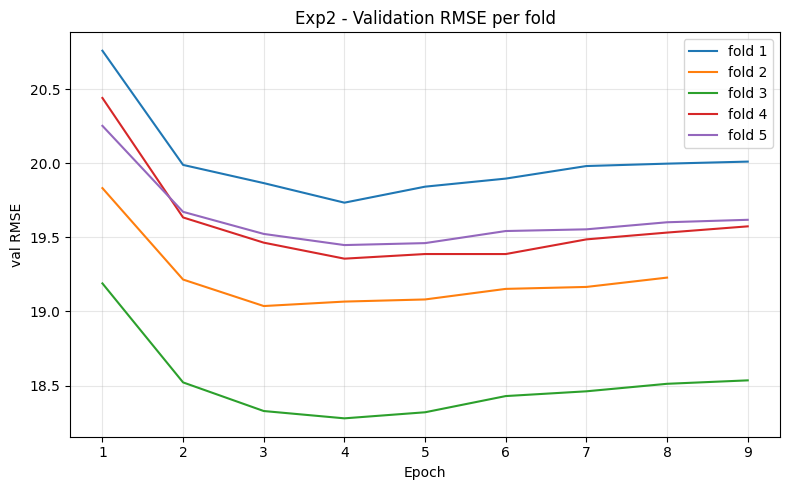

In [12]:
from src.plot import plot_all_folds_history
plot_all_folds_history(out_dir, folds=[1,2,3,4,5], title_prefix="Exp2")


In [6]:
# Worst error images 
errors_path = os.path.join(out_dir, "top50_errors.csv")
err_df = pd.read_csv(errors_path)
err_df.head()


Id  fold  ytrue   oof_pred    abs_err
0  73f9e8a6d0926f7c5201f034406d986d     4    100  14.601366  85.398634
1  3d69187b44aba9adbd7fd5f0d3554cd1     5      7  90.436104  83.436104
2  76769dbee1699e04ae1befa3128db7d6     2    100  22.297667  77.702333
3  ee7d8deda7e7e353f9d7866fe8d5ef04     5    100  23.146799  76.853201
4  deb8d1618d0cdc2a78c8198b882ebb2b     3    100  24.376383  75.623617

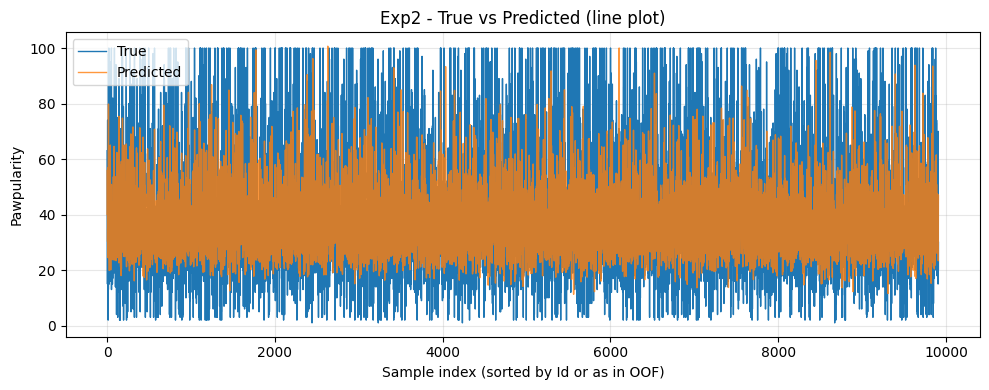

In [4]:
import os
import pandas as pd
from src.plot import (
   plot_oof_true_pred_lines,
    show_images_grid,
)

# Load OOF detail and top-errors
oof_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))
err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

# Plots
plot_oof_true_pred_lines(oof_df, title_prefix="Exp2")





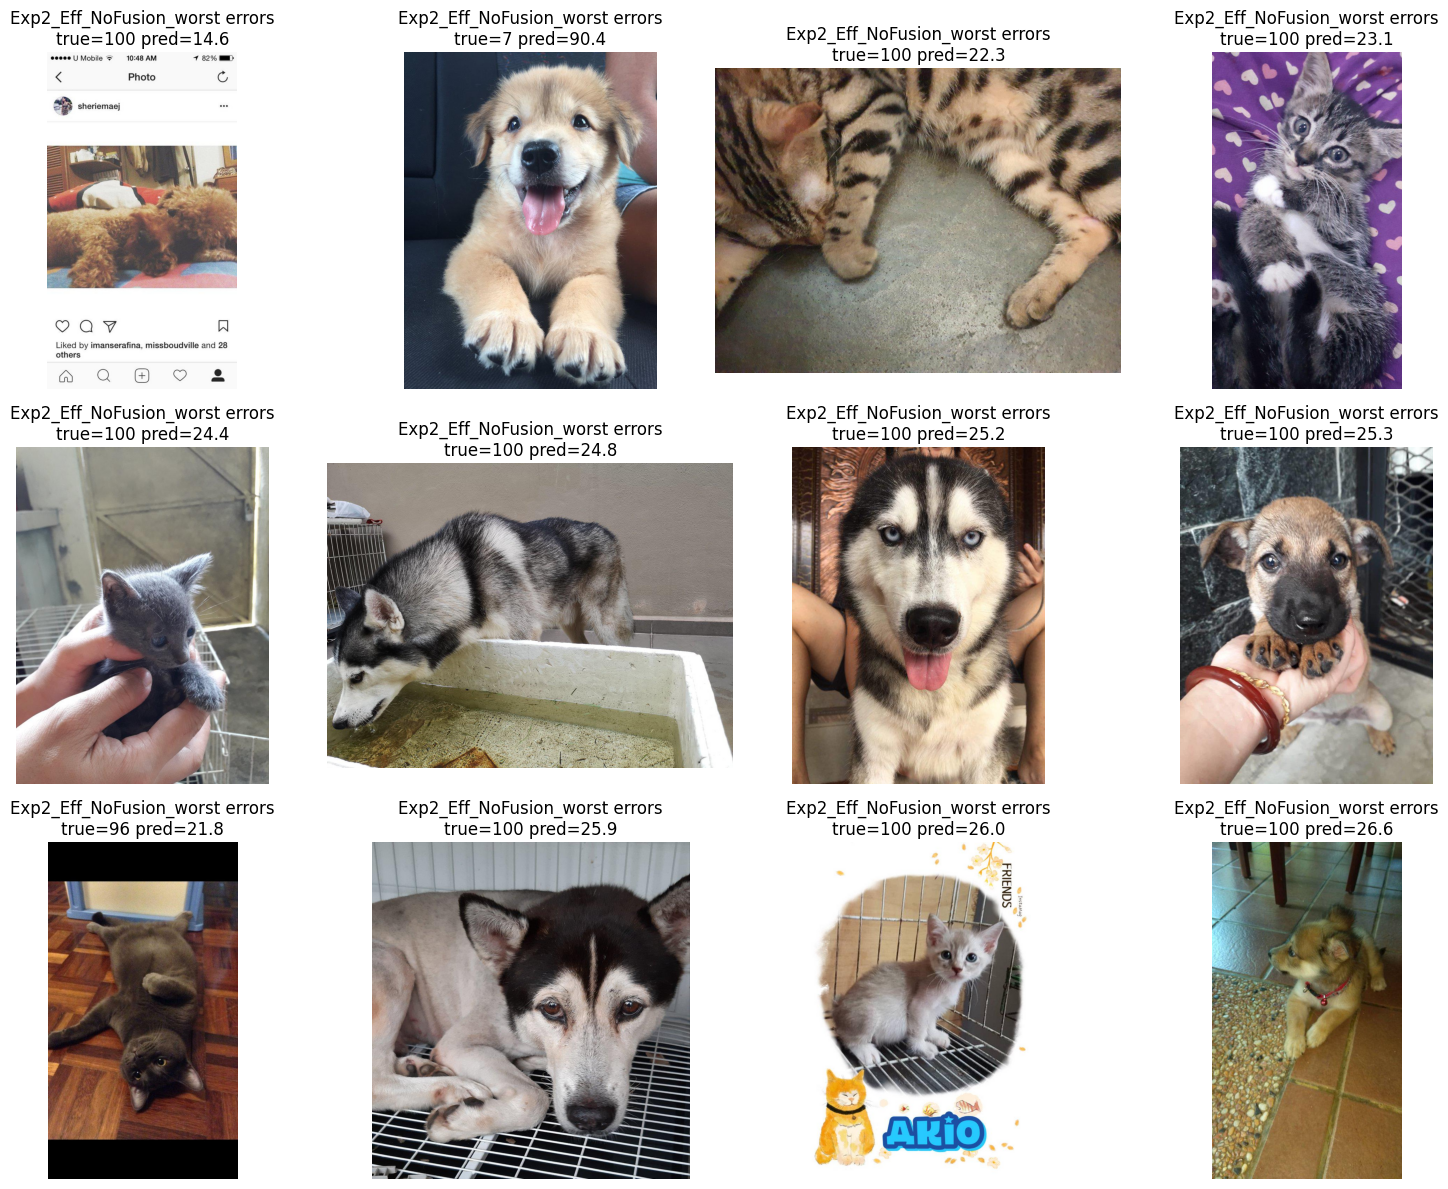

In [5]:
# Images of worst errors
img_folder = os.path.join(main_folder, "data", "train")
show_images_grid(err_df, img_folder, n=12, title_prefix="Exp2_Eff_NoFusion_worst errors")

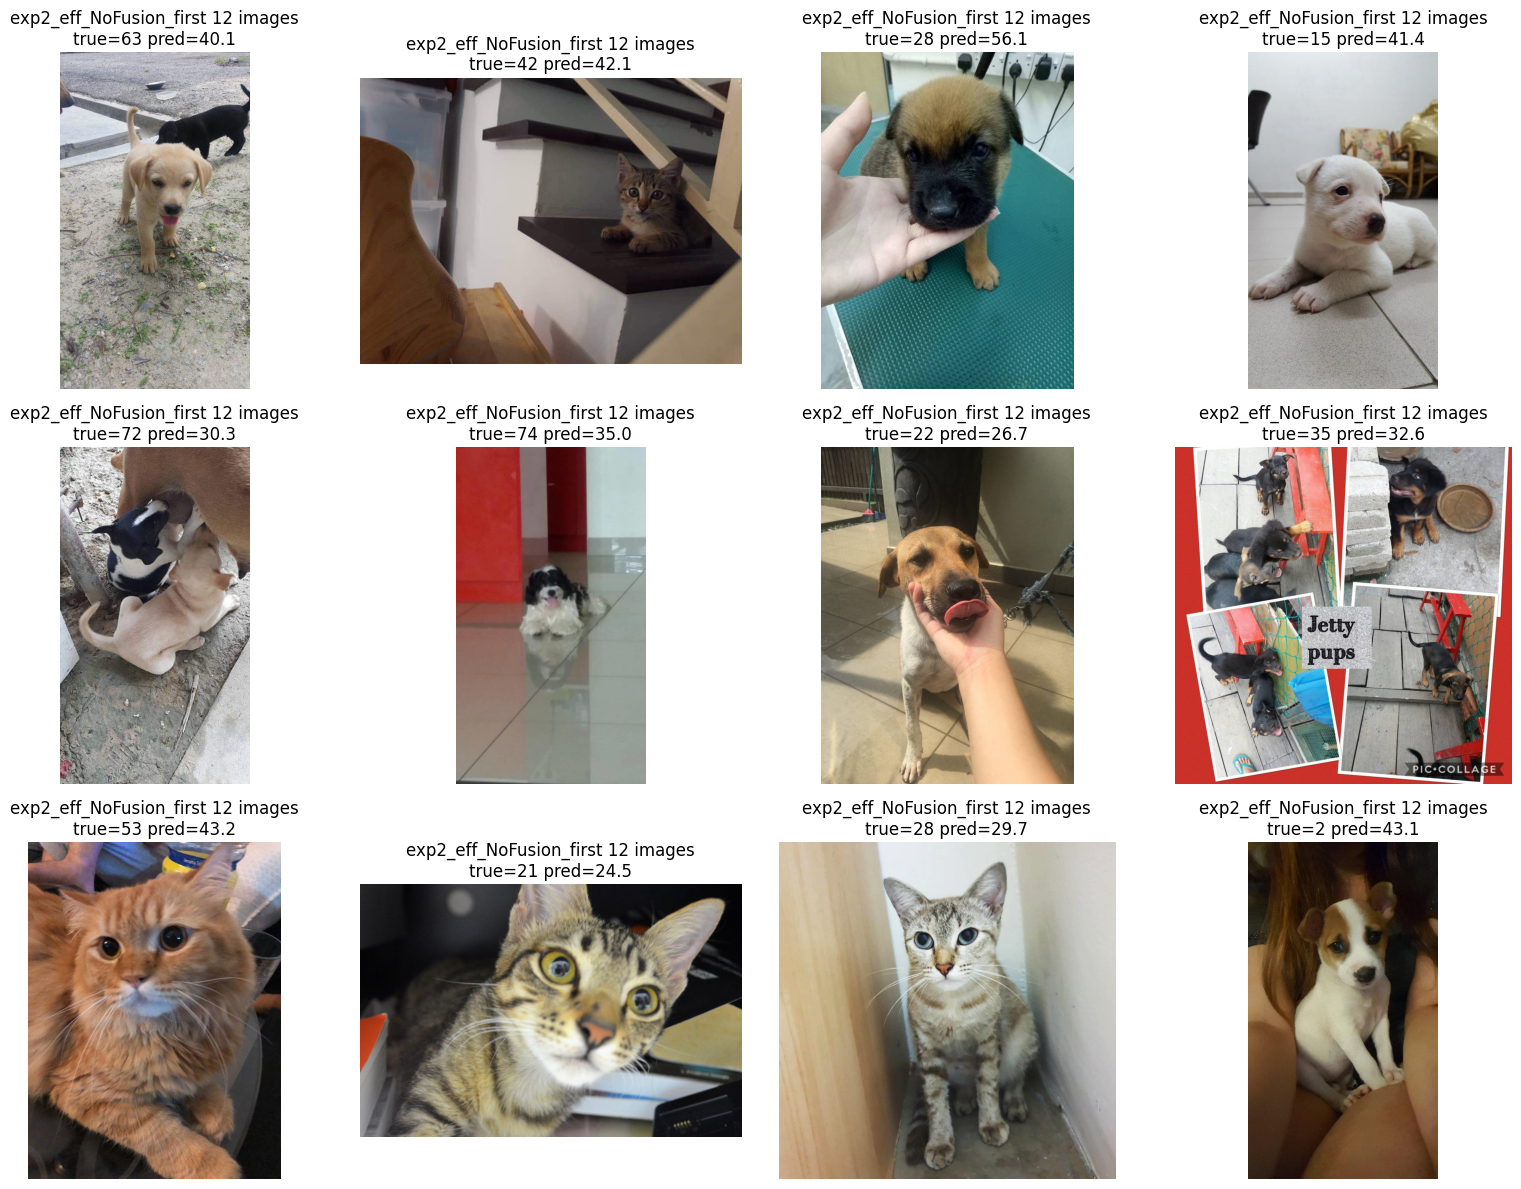

In [7]:

show_images_grid(oof_df, img_folder, n=12, title_prefix="exp2_eff_NoFusion_first 12 images")